In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7815146385836730446
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14465892352
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16662704479162213535
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [3]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 7.9 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=a0709e1a991dfd96af3972028b0a7a88d2621b6c8c0291102a046bfff2c33ef8
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [4]:
from google.colab import files
files.upload() #upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jyothishkumar","key":"70cfcdd9954fa33d0b9285a3f0c84070"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!cat ~/.kaggle/kaggle.json 
!chmod 600 ~/.kaggle/kaggle.json

{"username":"jyothishkumar","key":"70cfcdd9954fa33d0b9285a3f0c84070"}

In [6]:
!kaggle datasets download -d gpiosenka/sports-classification

 97% 465M/477M [00:03<00:00, 179MB/s]
100% 477M/477M [00:03<00:00, 140MB/s]


In [7]:
!mkdir sports-dataset
!unzip /content/sports-classification.zip -d sports-dataset 
!rm /content/sports-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: sports-dataset/train/rings/058.jpg  
  inflating: sports-dataset/train/rings/059.jpg  
  inflating: sports-dataset/train/rings/060.jpg  
  inflating: sports-dataset/train/rings/061.jpg  
  inflating: sports-dataset/train/rings/062.jpg  
  inflating: sports-dataset/train/rings/063.jpg  
  inflating: sports-dataset/train/rings/064.jpg  
  inflating: sports-dataset/train/rings/065.jpg  
  inflating: sports-dataset/train/rings/066.jpg  
  inflating: sports-dataset/train/rings/067.jpg  
  inflating: sports-dataset/train/rings/068.jpg  
  inflating: sports-dataset/train/rings/069.jpg  
  inflating: sports-dataset/train/rings/070.jpg  
  inflating: sports-dataset/train/rings/071.jpg  
  inflating: sports-dataset/train/rings/072.jpg  
  inflating: sports-dataset/train/rings/073.jpg  
  inflating: sports-dataset/train/rings/074.jpg  
  inflating: sports-dataset/train/rings/075.jpg  
  inflating: sports-dataset/train/rings/076.jpg  

In [8]:
import numpy as np 
import pandas as pd 


import os
for dirname, _, filenames in os.walk('/content/sports-dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/content/sports-dataset/train/trapeze/064.jpg
/content/sports-dataset/train/trapeze/020.jpg
/content/sports-dataset/train/trapeze/076.jpg
/content/sports-dataset/train/trapeze/025.jpg
/content/sports-dataset/train/trapeze/041.jpg
/content/sports-dataset/train/trapeze/073.jpg
/content/sports-dataset/train/trapeze/034.jpg
/content/sports-dataset/train/trapeze/014.jpg
/content/sports-dataset/train/trapeze/072.jpg
/content/sports-dataset/train/trapeze/099.jpg
/content/sports-dataset/train/trapeze/082.jpg
/content/sports-dataset/train/trapeze/037.jpg
/content/sports-dataset/train/trapeze/131.jpg
/content/sports-dataset/train/trapeze/062.jpg
/content/sports-dataset/train/trapeze/095.jpg
/content/sports-dataset/train/trapeze/098.jpg
/content/sports-dataset/train/trapeze/005.jpg
/content/sports-dataset/train/trapeze/050.jpg
/content/sports-dataset/train/trapeze/003.jpg
/content/sports-dataset/train/trapeze/071.jpg
/content/sports-dataset/train

In [11]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,GlobalAveragePooling2D,BatchNormalization
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import gradient_descent_v2,adam_v2
from keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import TensorBoard, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

%load_ext tensorboard



#Helper libraries
import random
import matplotlib.pyplot as plt
import datetime


print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
print("Number of accelerators: ", strategy.num_replicas_in_sync)



2.7.0
Num GPUs Available:  1
Number of accelerators:  1


In [12]:
# Defining the working directories

work_dir = '/content/sports-dataset'
os.listdir(work_dir) 
train_path = '/content/sports-dataset/train'

In [20]:
train_data = pd.read_csv(work_dir + '/sports.csv')
train_data.head()

,filepaths,labels,data set
0,train/air hockey/001.jpg,air hockey,train
1,train/air hockey/002.jpg,air hockey,train
2,train/air hockey/003.jpg,air hockey,train
3,train/air hockey/004.jpg,air hockey,train
4,train/air hockey/005.jpg,air hockey,train


In [21]:
total_nums = train_data.shape[0]
total_nums

13572

In [22]:
print(train_data['labels'].value_counts())

formula 1 racing      191
football              191
nascar racing         190
baseball              174
hockey                172
                     ... 
horseshoe pitching    102
arm wrestling          99
ultimate               99
wingsuit flying        98
sky surfing            59
Name: labels, Length: 100, dtype: int64


In [23]:
num_classes = len(train_data.labels.unique())
num_classes

100

In [30]:
count_sports = train_data['labels'].value_counts()
count_sports

formula 1 racing      191
football              191
nascar racing         190
baseball              174
hockey                172
                     ... 
horseshoe pitching    102
arm wrestling          99
ultimate               99
wingsuit flying        98
sky surfing            59
Name: labels, Length: 100, dtype: int64

In [50]:
#importing necessary libraries
import cv2
IMG_SIZE = 224


In [76]:
train_datagen = ImageDataGenerator(#rescale = 1./255., # rescaling
                                   featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False,
                                    samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=60,
                                    width_shift_range=0.3, height_shift_range=0.3, brightness_range=[0.1, 1.5], shear_range=30, zoom_range=[0.5, 1.5],
                                    channel_shift_range=90, fill_mode="nearest", cval=190, horizontal_flip=True, vertical_flip=True,
                                    rescale=1.0/255., preprocessing_function=None, data_format=None, validation_split=0.2, dtype=None)

val_datagen = ImageDataGenerator(rescale = 1.0/255.,
                                 validation_split = 0.2)

train_generator = train_datagen.flow_from_directory(directory= train_path,
                                                    batch_size = 64,
                                                    subset="training",
                                                    seed=42,
                                                    shuffle=True,
                                                    class_mode = 'sparse', 
                                                    target_size = (IMG_SIZE,IMG_SIZE))

val_generator = val_datagen.flow_from_directory(directory = train_path,
                                                    batch_size = 64,
                                                    subset = "validation",
                                                    seed=42,
                                                    shuffle=True,
                                                    class_mode = 'sparse', 
                                                    target_size = (IMG_SIZE,IMG_SIZE))

Found 10898 images belonging to 100 classes.
Found 2674 images belonging to 100 classes.


In [77]:
train_generator.class_indices

{'air hockey': 0,
 'ampute football': 1,
 'archery': 2,
 'arm wrestling': 3,
 'axe throwing': 4,
 'balance beam': 5,
 'barell racing': 6,
 'baseball': 7,
 'basketball': 8,
 'baton twirling': 9,
 'bike polo': 10,
 'billiards': 11,
 'bmx': 12,
 'bobsled': 13,
 'bowling': 14,
 'boxing': 15,
 'bull riding': 16,
 'bungee jumping': 17,
 'canoe slamon': 18,
 'cheerleading': 19,
 'chuckwagon racing': 20,
 'cricket': 21,
 'croquet': 22,
 'curling': 23,
 'disc golf': 24,
 'fencing': 25,
 'field hockey': 26,
 'figure skating men': 27,
 'figure skating pairs': 28,
 'figure skating women': 29,
 'fly fishing': 30,
 'football': 31,
 'formula 1 racing': 32,
 'frisbee': 33,
 'gaga': 34,
 'giant slalom': 35,
 'golf': 36,
 'hammer throw': 37,
 'hang gliding': 38,
 'harness racing': 39,
 'high jump': 40,
 'hockey': 41,
 'horse jumping': 42,
 'horse racing': 43,
 'horseshoe pitching': 44,
 'hurdles': 45,
 'hydroplane racing': 46,
 'ice climbing': 47,
 'ice yachting': 48,
 'jai alai': 49,
 'javelin': 50,
 '

In [78]:
class_weights_sports = {}
i= 0


for key in train_generator.class_indices.keys():
    class_weights_sports[i] = total_nums / (num_classes * count_sports[key])
    i+=1

class_weights_sports 

{0: 1.2117857142857142,
 1: 1.2117857142857142,
 2: 1.028181818181818,
 3: 1.3709090909090909,
 4: 1.2010619469026549,
 5: 0.8928947368421053,
 6: 1.1034146341463416,
 7: 0.78,
 8: 0.803076923076923,
 9: 1.2566666666666666,
 10: 1.2227027027027026,
 11: 0.936,
 12: 0.9694285714285714,
 13: 0.9834782608695652,
 14: 1.131,
 15: 1.17,
 16: 0.9108724832214765,
 17: 1.08576,
 18: 0.827560975609756,
 19: 1.028181818181818,
 20: 1.131,
 21: 1.044,
 22: 0.9979411764705882,
 23: 0.9625531914893617,
 24: 1.1034146341463416,
 25: 1.0053333333333334,
 26: 0.8589873417721519,
 27: 0.9295890410958904,
 28: 0.8988079470198675,
 29: 0.8535849056603774,
 30: 1.0128358208955224,
 31: 0.7105759162303665,
 32: 0.7105759162303665,
 33: 1.020451127819549,
 34: 1.1501694915254237,
 35: 0.8988079470198675,
 36: 0.8644585987261146,
 37: 1.1124590163934427,
 38: 1.1124590163934427,
 39: 0.923265306122449,
 40: 0.8535849056603774,
 41: 0.7890697674418604,
 42: 0.9906569343065693,
 43: 0.9764028776978417,
 44: 1.

In [79]:
def plot_images(data_generator=None):
    plt.figure(figsize=(10, 10))
    if data_generator is not None:
        images,labels=data_generator.next()
        for i in range(16):
            ax = plt.subplot(4, 4, i + 1)
            images[i,:,:,:]=images[i,:,:,:]*255.0
            plt.xticks([])
            plt.yticks([])
            plt.imshow(images[i,:,:,:].astype("uint8"))
            #plt.title(class_names[int(labels[i][0])])
            #plt.title(train_generator.class_indices.index(i))
            plt.title(np.argmax(labels[i]).astype(str))
            #plt.xlabel(train_data_modified.loc[train_data_modified['label'] == disease_title, 'disease_name'].item())
            
            #plt.axis("off")

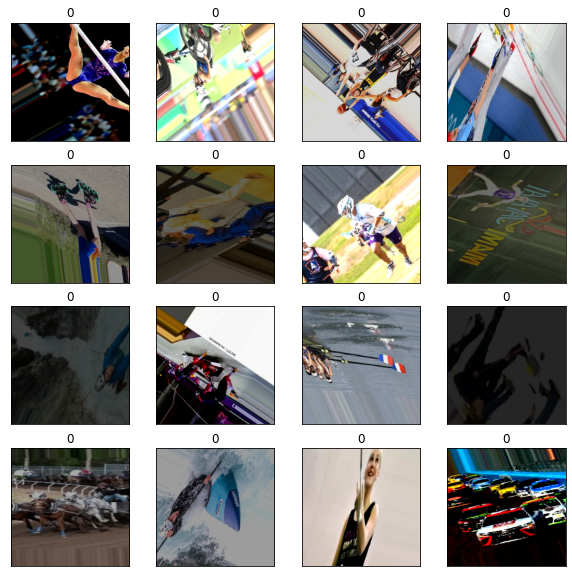

In [80]:
plot_images(train_generator)

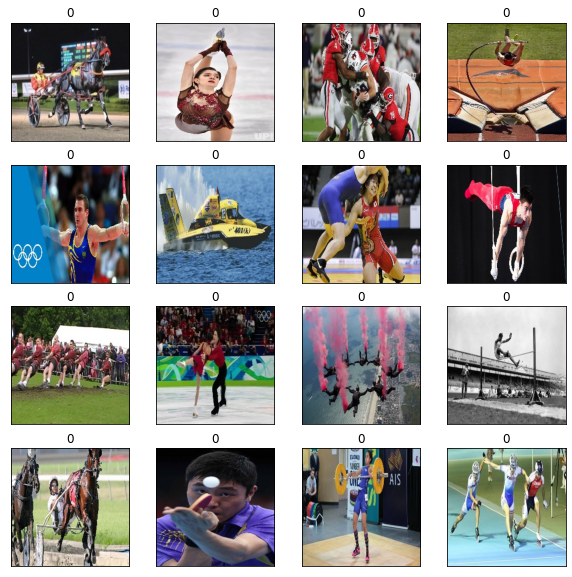

In [81]:
plot_images(val_generator)

In [82]:
# plotting helper function
def plotaccuracy(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [83]:
# plotting helper function
def plotloss(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [84]:
# define input shape
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

model_layers = keras.applications.Xception(weights='imagenet', include_top=False, 
                                               input_shape=INPUT_SHAPE)

model_layers.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [85]:
# Fine-tune all the layers
for layer in model_layers.layers:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in model_layers.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fee2e1238d0> False
<keras.layers.convolutional.Conv2D object at 0x7fee381a0e10> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fee3977e9d0> False
<keras.layers.core.activation.Activation object at 0x7fee39d78bd0> False
<keras.layers.convolutional.Conv2D object at 0x7fee3857d0d0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fee2e132790> False
<keras.layers.core.activation.Activation object at 0x7fee3858dd50> False
<keras.layers.convolutional.SeparableConv2D object at 0x7fee3858ded0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fee2e13c490> False
<keras.layers.core.activation.Activation object at 0x7fee2e117050> False
<keras.layers.convolutional.SeparableConv2D object at 0x7fed660b8d90> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fee2e117290> False
<keras.layers.convolutional.Co

In [86]:
# define sequential model
model = Sequential()

# Add the efficientNet convolutional base model
model.add(model_layers)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))

model.add(Dense(100, activation='softmax'))
#model_ResNet.add(Dense(35))
#SparseCategoricalCrossentropy(from_logits=True)
# compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

# view model layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 100)               204900    
                                                                 
Total params: 21,066,380
Trainable params: 204,900
Non-trainable params: 20,861,480
_________________________________________________________________


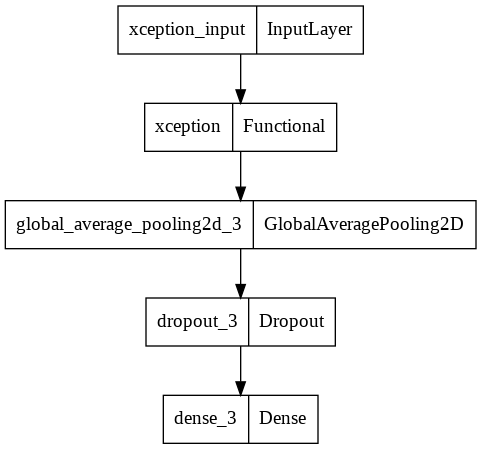

In [87]:
keras.utils.plot_model(model)

In [88]:
model_checkpoint = keras.callbacks.ModelCheckpoint(
    './best_weights.h5',
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="min"
)

es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode="min",
    restore_best_weights=True,
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=2,
    verbose=1,
    mode="min",
    min_delta=0.001,
)

In [89]:
EPOCHS = 50
BATCH_SIZE = 64

history = model.fit(train_generator,
                    validation_data = val_generator,
                    batch_size=BATCH_SIZE,
                    steps_per_epoch=(len(train_data)*0.8) // BATCH_SIZE,
                    validation_steps=(len(train_data)*0.2) // BATCH_SIZE,
                    callbacks = [model_checkpoint, es_callback, reduce_lr], 
                    epochs=EPOCHS,
                    #class_weight = class_weights_sports,
                    verbose=1)

 49/169 [=======>......................] - ETA: 1:51 - loss: 2.0482 - accuracy: 0.4672

KeyboardInterrupt: ignored

In [90]:
plotaccuracy(history)

NameError: ignored

In [91]:
plotloss(history)

NameError: ignored

In [92]:
model.save('/content/sports_classification_best_weights.h5')  

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
